In [1]:
#####################################################################################
## HW3: Question 1
## Author: Sai Lone
## Created: 11/29
## Edited:  
#####################################################################################

In [2]:
rm(list = ls())

# set working director
setwd("/Users/sailone/Desktop/fall19/EAS506/HW4")

In [3]:
install.packages("ElemStatLearn")
install.packages("bootstrap")
install.packages("leaps")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [4]:
# load required libaries
library(ElemStatLearn)
library(bootstrap)
library(boot)
library(leaps)

In [5]:
##################################
# load the on prostate data set in ElemStatLearn package
##################################
data(prostate)

In [49]:
dim(prostate)
head(prostate)

[1] 97 10

lcavol     lweight  age lbph      svi lcp       gleason pgg45 lpsa      
1 -0.5798185 2.769459 50  -1.386294 0   -1.386294 6        0    -0.4307829
2 -0.9942523 3.319626 58  -1.386294 0   -1.386294 6        0    -0.1625189
3 -0.5108256 2.691243 74  -1.386294 0   -1.386294 7       20    -0.1625189
4 -1.2039728 3.282789 58  -1.386294 0   -1.386294 6        0    -0.1625189
5  0.7514161 3.432373 62  -1.386294 0   -1.386294 6        0     0.3715636
6 -1.0498221 3.228826 50  -1.386294 0   -1.386294 6        0     0.7654678
  train
1 TRUE 
2 TRUE 
3 TRUE 
4 TRUE 
5 TRUE 
6 TRUE

In [7]:
##################################
# BestSubset linear regression using AIC and BIC
##################################
set.seed(1)
train = sample(1:nrow(prostate), .80*nrow(prostate))
Y.train = prostate$lpsa[train] # will use lpsa as the predictor 
Y.test = prostate$lpsa[-train]

training = prostate[train, 1:9]
testing = prostate[-train, 1:9]

fit <- regsubsets(lpsa~., data = training, method = "exhaustive", nvmax =  8)

In [8]:
best_subset_summary <- summary(fit)
names(best_subset_summary)

which.min(best_subset_summary$cp) #Cp says 3 variables is best
which.min(best_subset_summary$bic) #BIC says 3 variables is best

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

[1] 3

[1] 3

In [9]:
best_subset_summary$outmat
head(training)

lcavol lweight age lbph svi lcp gleason pgg45
1  ( 1 ) *                                            
2  ( 1 ) *                       *                    
3  ( 1 ) *      *                *                    
4  ( 1 ) *      *       *        *                    
5  ( 1 ) *      *       *   *    *                    
6  ( 1 ) *      *       *   *    *               *    
7  ( 1 ) *      *       *   *    *   *           *    
8  ( 1 ) *      *       *   *    *   *   *       *

lcavol       lweight  age lbph      svi lcp        gleason pgg45 lpsa      
68  2.198335072 4.050915 72   2.307573 0   -0.4307829 7       10     2.9626924
39  2.660958594 4.085136 68   1.373716 1    1.8325815 7       35     2.2137539
1  -0.579818495 2.769459 50  -1.386294 0   -1.3862944 6        0    -0.4307829
34  0.009950331 3.267666 54  -1.386294 0   -1.3862944 6        0     2.0215476
87  2.024193067 3.731699 58   1.638997 0   -1.3862944 6        0     3.6800909
43  0.582215620 3.865979 62   1.713798 0   -0.4307829 6        0     2.3272777

In [10]:
### So now lets do the selection based on the hold out method
select = best_subset_summary$outmat

In [ ]:
# store error prediction for aic and bic
aic.store<-c()
bic.store<-c()

In [21]:
# store error prediction for five-tenfold cross-validation method
cv.fivefold.store <- c()
cv.tenfold.store <- c()

In [37]:
# store error prediction for bootstrap .632 method
bootstrap632.store <- c()

# create functions that feed into "bootpred"
beta.fit <- function(X,Y){
    lsfit(X,Y)
}
beta.predict <- function(fit, X){
    cbind(1,X)%*%fit$coef
}
sq.error <- function(Y, Yhat){
    (Y-Yhat)^2
}

# Create X and Y
X <- prostate[,1:8]
Y <- prostate[,9]

In [45]:
for (i in 1:8){
    temp <- which(select[i,] == "*")
    
    red.training <- training[, c(9,temp)]
    red.testing <- testing[,c(9,temp)]
    # prediction for lm
    red.fit <- lm(lpsa~., data = red.training)
    # get the error using AIC and BIC method
    aic <- AIC(red.fit)
    bic <- BIC(red.fit)
    # Store the errors
    aic.store <- c(aic.store,aic)
    bic.store <- c(bic.store,bic)
    
    
    glm.data <- prostate[,c(9,temp)]
    # prediction of glm
    glm.fit <- glm(lpsa~.,data = glm.data)
    # get the error using five-tenfold method
    cv.fivefold <- cv.glm(data = glm.data, glmfit = glm.fit, K = 5)$delta[2]
    cv.tenfold <- cv.glm(data = glm.data, glmfit = glm.fit, K = 10)$delta[2]
    # Store the errors
    cv.fivefold.store <- c(cv.fivefold.store, cv.fivefold)
    cv.tenfold.store <- c(cv.tenfold.store, cv.tenfold)
    
    # get the error using bootstrap .632
    res.bootstrap <- bootpred(X[,temp], Y, nboot = 50, theta.fit = beta.fit, theta.predict =  beta.predict, err.meas = sq.error)
    bootstrap632.store <-c(bootstrap632.store, res.bootstrap[[3]])
    
}

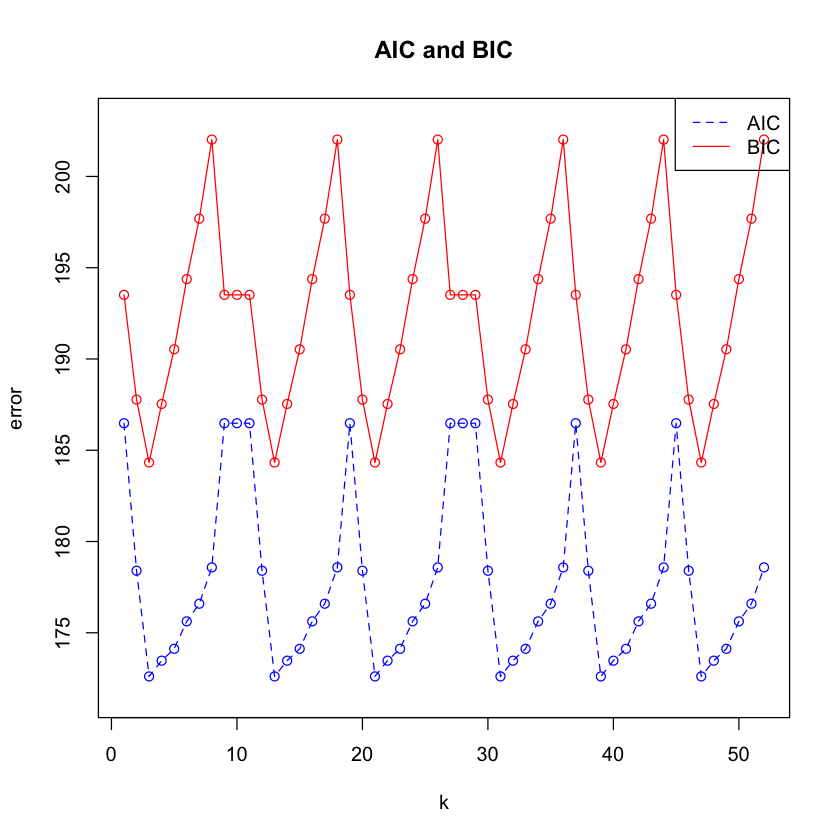

In [46]:
##################################
### Plot the results for aic and bic prediction error 
##################################
upper = max(aic.store,bic.store)
lower = min(aic.store,bic.store)

quartz()
plot(aic.store, type = "o", lty = 2, col = "blue", ylim = c(lower -1, upper +1) , xlab = "k", ylab = "error", main = "AIC and BIC")
lines(bic.store, type = "o", lty = 1, col = "red")
legend("topright", c("AIC", "BIC"), lty = c(2,1), col = c("blue", "red"))


[1] 0.6450471 0.5923042 0.5343685 0.5138130 0.5403722 0.5739123 0.5272943
 [8] 0.5535509 0.6376560 0.6237496 0.6471627 0.6192329 0.5732494 0.5030161
[15] 0.5357107 0.5132792 0.5123661 0.5312362

[1] 0.6544249 0.5840336 0.5294108 0.5539438 0.5407903 0.5367177 0.5292551
 [8] 0.5444553 0.6336265 0.5820987 0.5296356 0.5185690 0.5195629 0.5243778
[15] 0.5332233 0.5524900 0.6258579 0.6391159 0.6370332 0.5888940 0.5216258
[22] 0.5137357 0.5303647 0.5099913 0.5534094 0.5641453

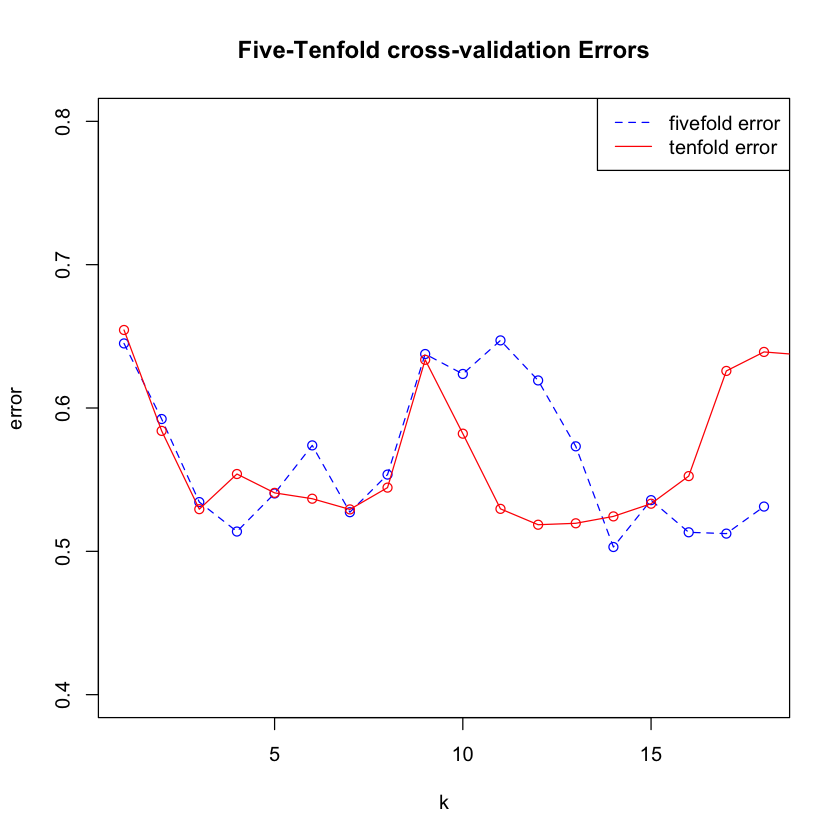

In [41]:
##################################
# Plot the results for five-tenfold cross-validation prediction error 
##################################
cv.fivefold.store
cv.tenfold.store

quartz()
plot(cv.fivefold.store,type="o",lty=2,col = "blue",ylim = c(0.4,0.8),xlab = "k",ylab="error",main="Five-Tenfold cross-validation Errors")
lines(cv.tenfold.store,type="o",lty=1,col="red")
legend("topright",c("fivefold error", "tenfold error"),lty=c(2,1),col=c("blue","red"))


[1] 0.6375165 0.5860047 0.5193077 0.5299114 0.5240400 0.5297600 0.5298899
 [8] 0.5433140 0.6294609 0.5885624 0.5170848 0.5181203 0.5093612 0.5195649
[15] 0.5299858 0.5366292

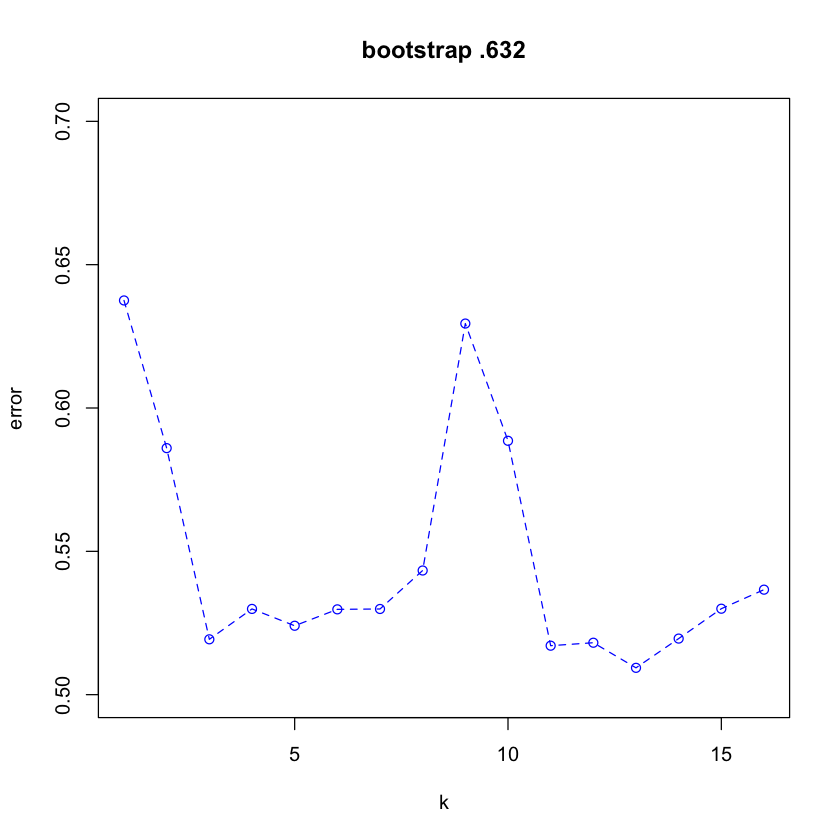

In [47]:
##################################
# bootstrap .632 method
##################################
bootstrap632.store

quartz()
plot(bootstrap632.store, type = "o", lty = 2, col = "blue", ylim = c(0.5,0.7) , xlab = "k", ylab = "error", main = "bootstrap .632")
